## Import Library

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from gensim.models import Word2Vec
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sheil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sheil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df = pd.read_csv('D:\\DBS Codiing Camp\\proyek_awal\\grab_reviews.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,appVersion,reviewDate,replyContent,repliedAt,appVersion.1
0,a869fe77-41cc-4e22-af78-9d19f3e7693b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,ojolnya baik dan ramah,5,0,5.351.1,2025-04-12 22:04:33,NaN,NaN,5.351.1
1,f0dfeb1c-b286-4764-91b4-6d124d3e745c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,terbaik,5,0,5.351.1,2025-04-12 21:57:20,NaN,NaN,5.351.1
2,9d0c5d4c-b9cd-4545-bf53-f937a8820e47,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"drivernya baik, ramah, sopan, mobil nyaman",5,0,5.351.1,2025-04-12 21:50:43,NaN,NaN,5.351.1
3,72d3dbaf-b090-4492-bbf5-b8840f12dd5f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,terlalu mhal,3,0,5.351.1,2025-04-12 21:47:02,NaN,NaN,5.351.1
4,160245a3-8071-40f0-ae9e-677858f0ce6d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,terimakasih,5,0,5.351.1,2025-04-12 21:36:00,NaN,NaN,5.351.1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reviewId       50000 non-null  object
 1   userName       50000 non-null  object
 2   userImage      50000 non-null  object
 3   content        50000 non-null  object
 4   score          50000 non-null  int64 
 5   thumbsUpCount  50000 non-null  int64 
 6   appVersion     42968 non-null  object
 7   reviewDate     50000 non-null  object
 8   replyContent   18453 non-null  object
 9   repliedAt      18453 non-null  object
 10  appVersion.1   42968 non-null  object
dtypes: int64(2), object(9)
memory usage: 4.2+ MB


In [9]:
# Membuat DataFrame baru (clean_df) dengan menghapus baris yang memiliki nilai yang hilang (NaN) dari df
clean_df = df.dropna()

In [11]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15338 entries, 247 to 49998
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reviewId       15338 non-null  object
 1   userName       15338 non-null  object
 2   userImage      15338 non-null  object
 3   content        15338 non-null  object
 4   score          15338 non-null  int64 
 5   thumbsUpCount  15338 non-null  int64 
 6   appVersion     15338 non-null  object
 7   reviewDate     15338 non-null  object
 8   replyContent   15338 non-null  object
 9   repliedAt      15338 non-null  object
 10  appVersion.1   15338 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.4+ MB


In [13]:
# Menghapus baris duplikat dari DataFrame clean_df
clean_df = clean_df.drop_duplicates()

# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape

In [15]:
print("Informasi Dataset:")
print(f"Jumlah sampel data: {len(clean_df)}")
print(f"Kolom yang tersedia: {', '.join(clean_df.columns)}")

Informasi Dataset:
Jumlah sampel data: 15338
Kolom yang tersedia: reviewId, userName, userImage, content, score, thumbsUpCount, appVersion, reviewDate, replyContent, repliedAt, appVersion.1


## Preprocessing Data

In [17]:
# Fungsi preprocessing
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Ubah ke huruf kecil semua
        text = re.sub(r'http\S+', '', text)  # Hapus URL
        text = re.sub(r'@\w+|#\w+', '', text)  # Hapus mention dan hashtag
        text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
        text = re.sub(r'\d+', '', text)  # Hapus angka
        text = re.sub(r'\s+', ' ', text).strip()  # Hapus spasi berlebih
        return text
    return ""

In [19]:
# Memeberi label
def label_sentiment(score):
    if score <= 2:
        return "negatif"
    elif score == 3:
        return "netral"
    else:
        return "positif"

In [21]:
# Terapkan fungsi clean_text ke kolom 'content'
clean_df['cleaned_content'] = df['content'].apply(clean_text)

# Tambahkan kolom label sentimen
clean_df['sentimen'] = df['score'].apply(label_sentiment)

# Konversi label sentimen ke kode numerik
sentiment_dict = {'negatif': 0, 'netral': 1, 'positif': 2}
clean_df['sentimen_kode'] = clean_df['sentimen'].map(sentiment_dict)

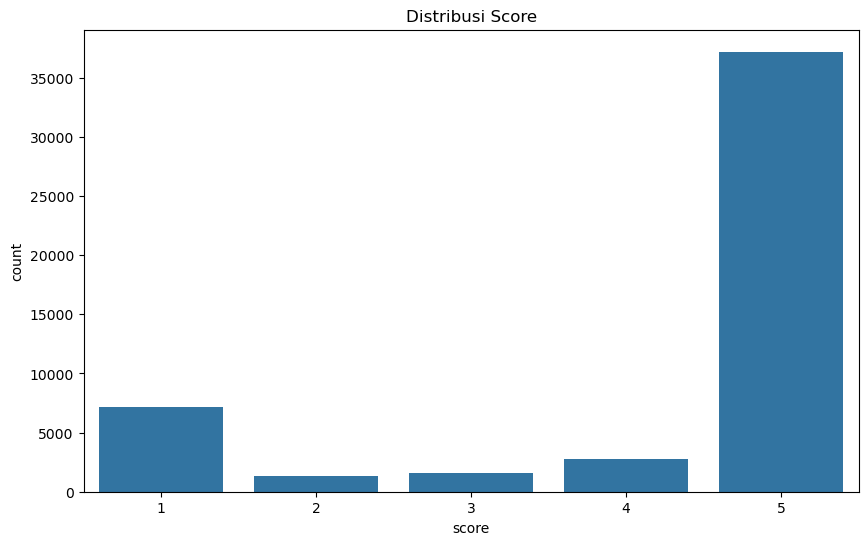

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(x='score', data=df)
plt.title('Distribusi Score')
plt.show()

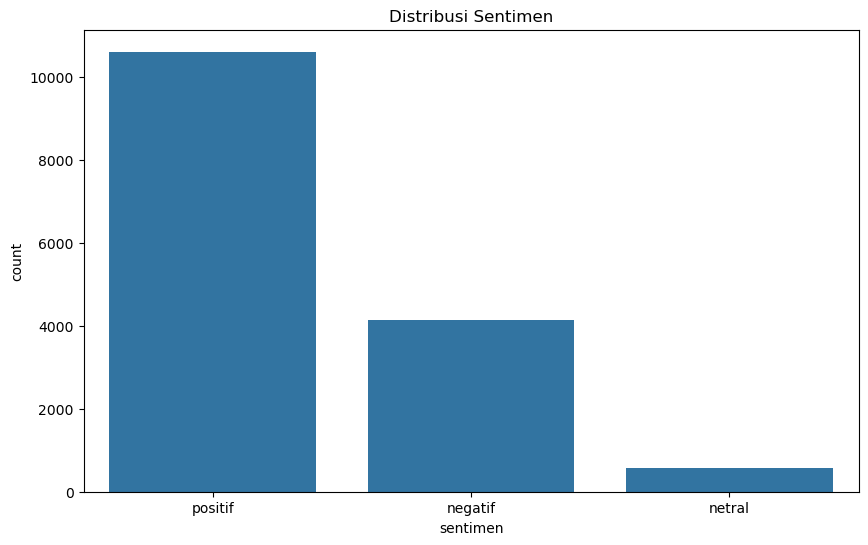

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(x='sentimen', data=clean_df)
plt.title('Distribusi Sentimen')
plt.show()

## Pembangunan Model

In [28]:
# Cek distribusi panjang teks
text_lengths = clean_df['cleaned_content'].str.len()
print(f"\nStatistik panjang teks:")
print(f"  Min: {text_lengths.min()}")
print(f"  Mean: {text_lengths.mean():.2f}")
print(f"  Median: {text_lengths.median()}")
print(f"  95 percentile: {text_lengths.quantile(0.95)}")
print(f"  Max: {text_lengths.max()}")

# Tentukan max_length berdasarkan persentil ke-95 atau nilai tetap
max_length = min(int(text_lengths.quantile(0.95)), 100)
print(f"Menggunakan max_length = {max_length} untuk padding")


Statistik panjang teks:
  Min: 0
  Mean: 47.95
  Median: 17.0
  95 percentile: 205.0
  Max: 497
Menggunakan max_length = 100 untuk padding


In [30]:
# hitung class_weight
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(clean_df['sentimen_kode'])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=clean_df['sentimen_kode'])
class_weight_dict = dict(zip(classes, class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: 1.2334539605950945, 1: 8.754566210045661, 2: 0.4819178684764508}


In [32]:
# Memisahkan fitur dan target
X = clean_df['cleaned_content']
y = clean_df['sentimen_kode']

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Jumlah data training: {X_train.shape[0]}")
print(f"Jumlah data testing: {X_test.shape[0]}")

Jumlah data training: 12270
Jumlah data testing: 3068


## SVM + TFIDF

In [35]:
# Ekstraksi fitur menggunakan TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [37]:
# Melatih Model SVM
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', C=1.0, probability=True, class_weight=class_weight_dict)
svm_model.fit(X_train_tfidf, y_train)

SVC(class_weight={0: 1.2334539605950945, 1: 8.754566210045661,
                  2: 0.4819178684764508},
    kernel='linear', probability=True)

In [38]:
# Evaluasi data training dan testing
y_train_predict_svm = svm_model.predict(X_train_tfidf)
train_accuracy_svm = accuracy_score(y_train, y_train_predict_svm)

y_test_predict_svm = svm_model.predict(X_test_tfidf)
test_accuracy_svm = accuracy_score(y_test, y_test_predict_svm)

print(f"SVM Training Accuracy: {train_accuracy_svm:.4f}")
print(f"SVM Testing Accuracy: {test_accuracy_svm:.4f}")
print("\nClassification Report (Testing): ")
print(classification_report(y_test, y_test_predict_svm))

SVM Training Accuracy: 0.9392
SVM Testing Accuracy: 0.8699

Classification Report (Testing): 
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       829
           1       0.12      0.16      0.14       117
           2       0.95      0.93      0.94      2122

    accuracy                           0.87      3068
   macro avg       0.63      0.64      0.63      3068
weighted avg       0.88      0.87      0.88      3068



In [39]:
# Simpan model dan vectorizer
joblib.dump(svm_model, 'model_svm.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

## BOW + Random Forest

In [41]:
# Split data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42, stratify=clean_df['sentimen_kode'])

In [42]:
# Ekstraksi fitur Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train1)
X_test_bow = bow_vectorizer.transform(X_test1)

In [43]:
# Melatih model Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, class_weight=class_weight_dict)
rf_model.fit(X_train_bow, y_train1)

RandomForestClassifier(class_weight={0: 1.2334539605950945,
                                     1: 8.754566210045661,
                                     2: 0.4819178684764508},
                       max_depth=20, n_estimators=200, random_state=42)

In [44]:
# Evaluasi
y_train_predict_rf = rf_model.predict(X_train_bow)
train_accuracy_rf = accuracy_score(y_train1, y_train_predict_rf)

y_test_predict_rf = rf_model.predict(X_test_bow)
test_accuracy_rf = accuracy_score(y_test1, y_test_predict_rf)

print(f"Random Forest Training Accuracy: {train_accuracy_rf:.4f}")
print(f"Random Forest Testing Accuracy: {test_accuracy_rf:.4f}")
print("\nClassification Report (Testing): ")
print(classification_report(y_test1, y_test_predict_rf))

Random Forest Training Accuracy: 0.9072
Random Forest Testing Accuracy: 0.8753

Classification Report (Testing): 
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1244
           1       0.29      0.01      0.02       175
           2       0.91      0.95      0.93      3183

    accuracy                           0.88      4602
   macro avg       0.66      0.59      0.58      4602
weighted avg       0.85      0.88      0.86      4602



In [45]:
# Simpan model dan vectorizer
joblib.dump(rf_model, 'model_rf.pkl')
joblib.dump(bow_vectorizer, 'bow_vectorizer.pkl')

['bow_vectorizer.pkl']

## CNN + LSTM

In [47]:
# Tokenisasi untuk Deep Learning
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X)

In [48]:
# Konversi teks ke urutan angka
X_sequences = tokenizer.texts_to_sequences(X)

# Padding sequences ke panjang yang sama
max_length = 200
X_padded = pad_sequences(X_sequences, maxlen=max_length)

In [49]:
# Split data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_padded, y, test_size=0.2, random_state=42, stratify=clean_df['sentimen_kode'])

In [50]:
# Model CNN + LSTM
cnn_lstm_model = Sequential([
    Embedding(20000, 128, input_length=max_length),

    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),

    LSTM(64),
    Dropout(0.5),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax') # 3 kelas: negatif, netral, positif
])

# Kompilasi model
cnn_lstm_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

In [51]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# latih model
history = cnn_lstm_model.fit(
    X_train2, y_train2,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.7276 - loss: 0.9538 - val_accuracy: 0.9169 - val_loss: 0.5898
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.8634 - loss: 0.7647 - val_accuracy: 0.8663 - val_loss: 0.5292
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8862 - loss: 0.6238 - val_accuracy: 0.8484 - val_loss: 0.4478
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.9245 - loss: 0.4155 - val_accuracy: 0.8680 - val_loss: 0.5159
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.9476 - loss: 0.3214 - val_accuracy: 0.8582 - val_loss: 0.5440
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.9542 - loss: 0.3083 - val_accuracy: 0.8590 - val_loss: 0.6417


In [52]:
# Evaluasi model pada data training dan testing
train_loss, train_accuracy_cnn_lstm = cnn_lstm_model.evaluate(X_train2, y_train2, verbose=0)
test_loss, test_accuracy_cnn_lstm = cnn_lstm_model.evaluate(X_test2, y_test2, verbose=0)

print(f"CNN + LSTM Training Accuracy: {train_accuracy_cnn_lstm:.4f}")
print(f"CNN + LSTM Testing Accuracy: {test_accuracy_cnn_lstm:.4f}")

CNN + LSTM Training Accuracy: 0.9088
CNN + LSTM Testing Accuracy: 0.8246


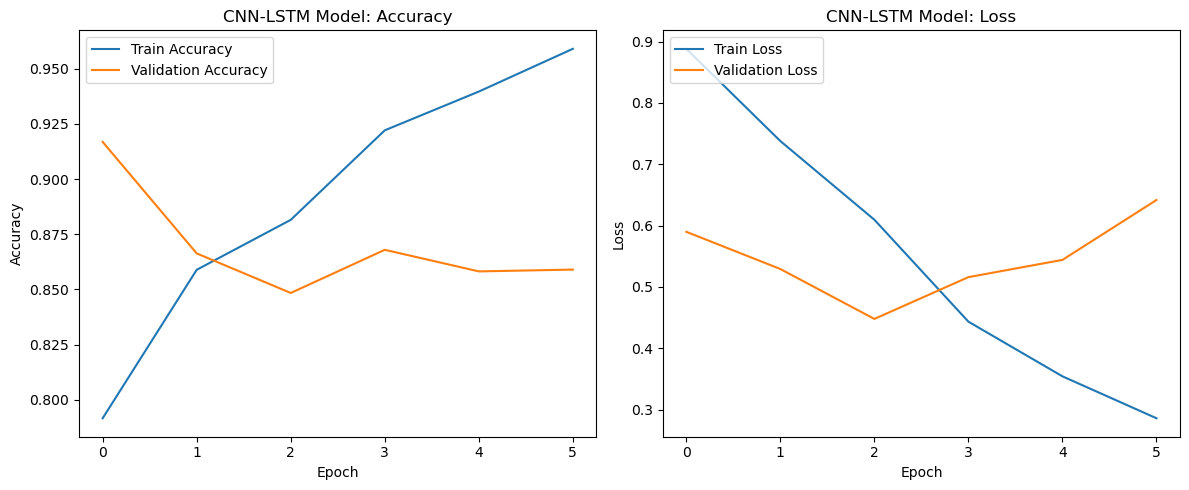

In [53]:
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-LSTM Model: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM Model: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [54]:
print("\nPerbandingan Accuracy Ketiga Model")
compare = pd.DataFrame({
    'Model': ['SVM + TFIDF', 'BOW + RANDOM FOREST', 'CNN + LSTM'],
    'Akurasi Training': [
        train_accuracy_svm*100,
        train_accuracy_rf*100,
        train_accuracy_cnn_lstm*100
    ],
    'Akurasi Testing': [
        test_accuracy_svm*100,
        test_accuracy_rf*100,
        test_accuracy_cnn_lstm*100
    ]
})
print(compare)


Perbandingan Accuracy Ketiga Model
                 Model  Akurasi Training  Akurasi Testing
0          SVM + TFIDF         93.920130        86.994785
1  BOW + RANDOM FOREST         90.722802        87.527162
2           CNN + LSTM         90.880197        82.464147


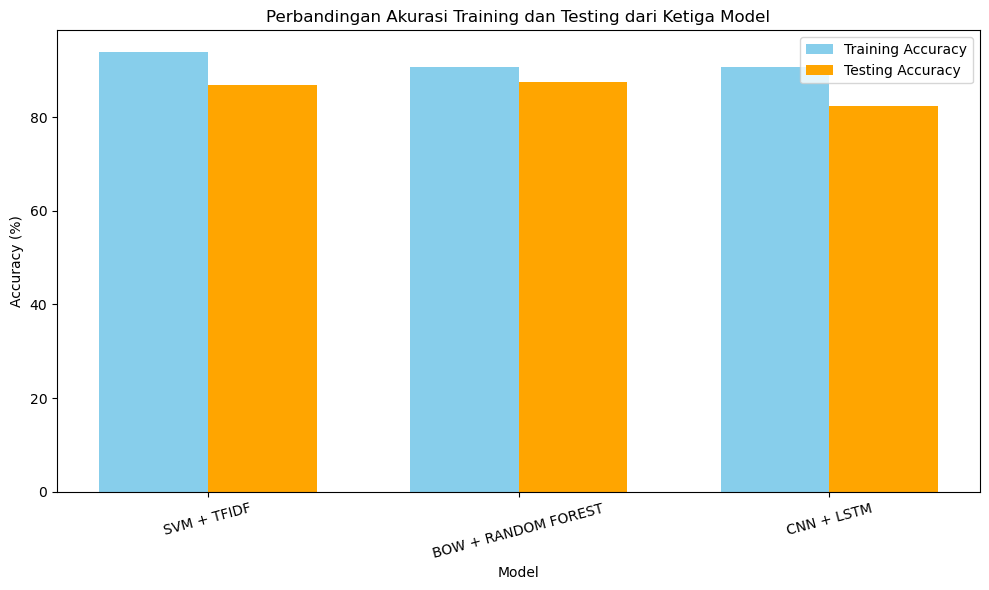

In [55]:
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(compare))

plt.bar(index, compare['Akurasi Training'], bar_width, label='Training Accuracy', color='skyblue')
plt.bar([i + bar_width for i in index], compare['Akurasi Testing'], bar_width, label='Testing Accuracy', color='orange')

plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Perbandingan Akurasi Training dan Testing dari Ketiga Model')
plt.xticks([i + bar_width / 2 for i in index], compare['Model'], rotation=15)
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
# Menentukan model terbaik berdasarkan akurasi testing
best_model = compare.loc[compare['Akurasi Testing'].idxmax()]

print("Model terbaik berdasarkan Akurasi Testing:")
print(best_model)

Model terbaik berdasarkan Akurasi Testing:
Model               BOW + RANDOM FOREST
Akurasi Training              90.722802
Akurasi Testing               87.527162
Name: 1, dtype: object
